#1. Data Preprocessing & Cleaning

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [ ]:
# Load the dataset
df = pd.read_csv(r"/content/heart_disease.csv")

In [ ]:
# Check for missing values
print(df.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64


In [ ]:
# Handle missing values (simple imputation for now)
imputer = SimpleImputer(strategy='median')
df['ca'] = imputer.fit_transform(df[['ca']])
df['thal'] = imputer.fit_transform(df[['thal']])

In [ ]:
# Convert 'num' to binary classification (0 = no disease, 1-4 = disease)
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df.drop('num', axis=1, inplace=True)

In [ ]:
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['cp', 'restecg', 'slope', 'thal'], drop_first=True)

In [ ]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

In [ ]:
# Standardize numerical features
scaler = StandardScaler()
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
X[num_cols] = scaler.fit_transform(X[num_cols])

#2. Exploratory Data Analysis (EDA)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

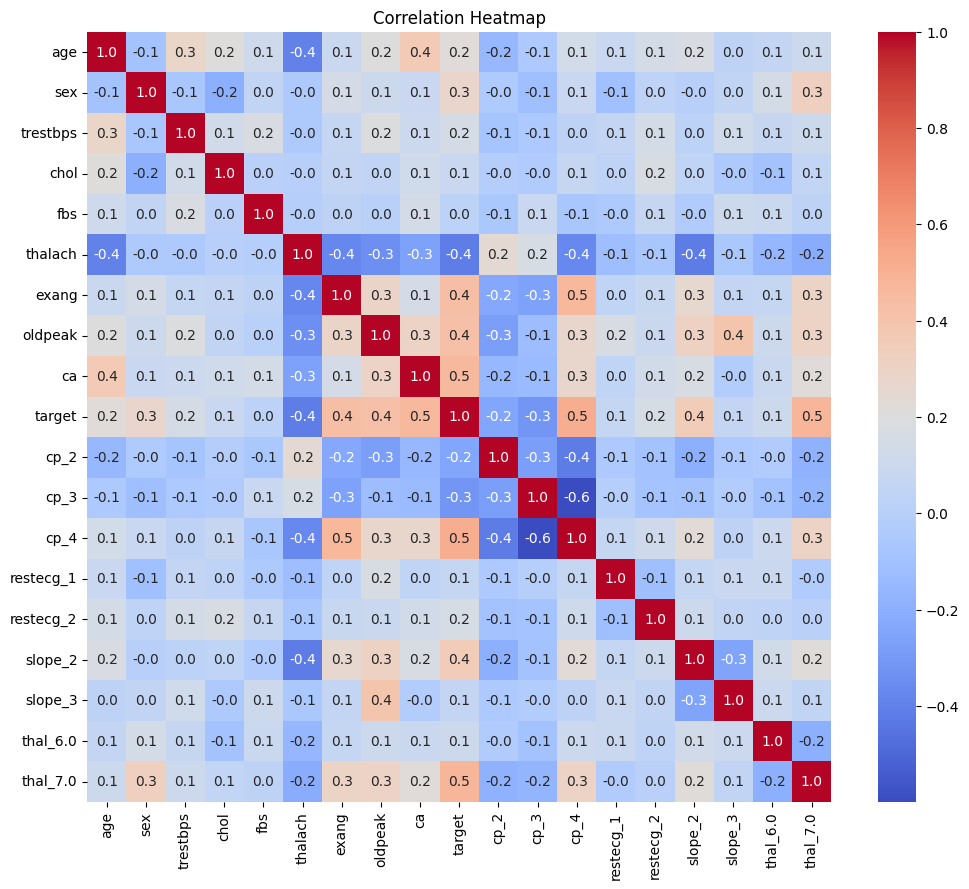

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

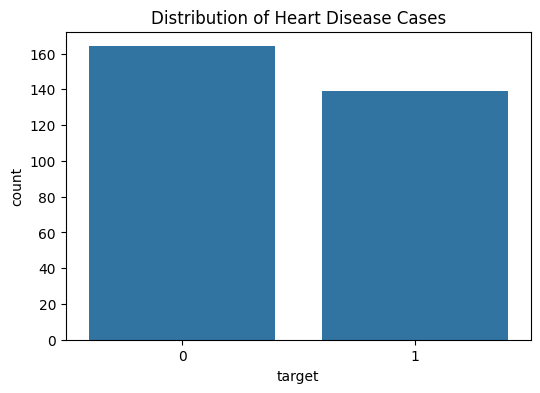

In [ ]:
# Target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Distribution of Heart Disease Cases')
plt.show()

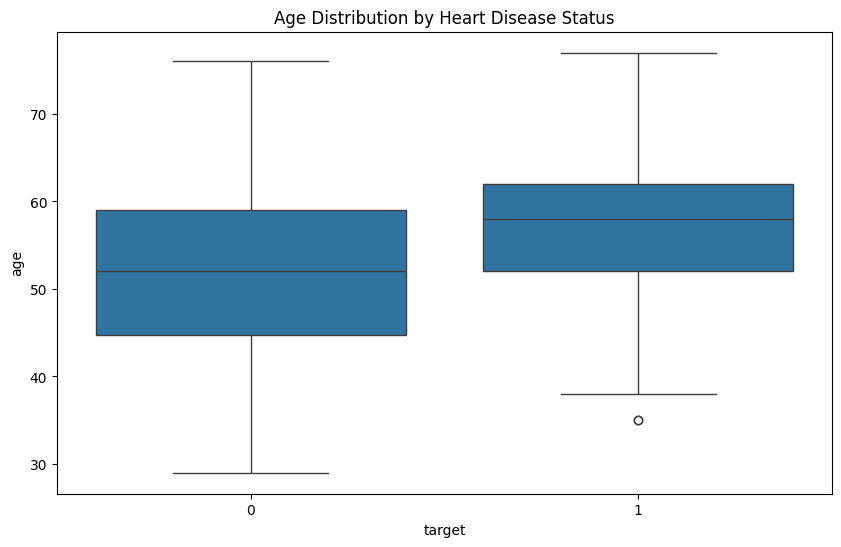

In [ ]:
# Age distribution by target
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='age', data=df)
plt.title('Age Distribution by Heart Disease Status')
plt.show()

#3. Dimensionality Reduction (PCA)

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X)

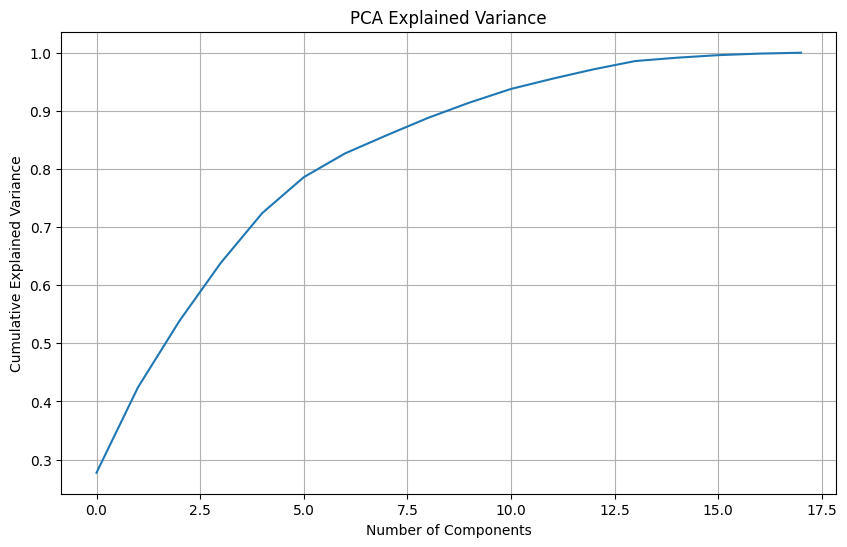

In [ ]:
# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

In [ ]:
# Select number of components explaining 95% variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")

Number of components explaining 95% variance: 12


In [ ]:
# Final PCA with selected components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

#4. Feature Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2

In [ ]:
# Feature importance with Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
importance = importance.sort_values('Importance', ascending=False)

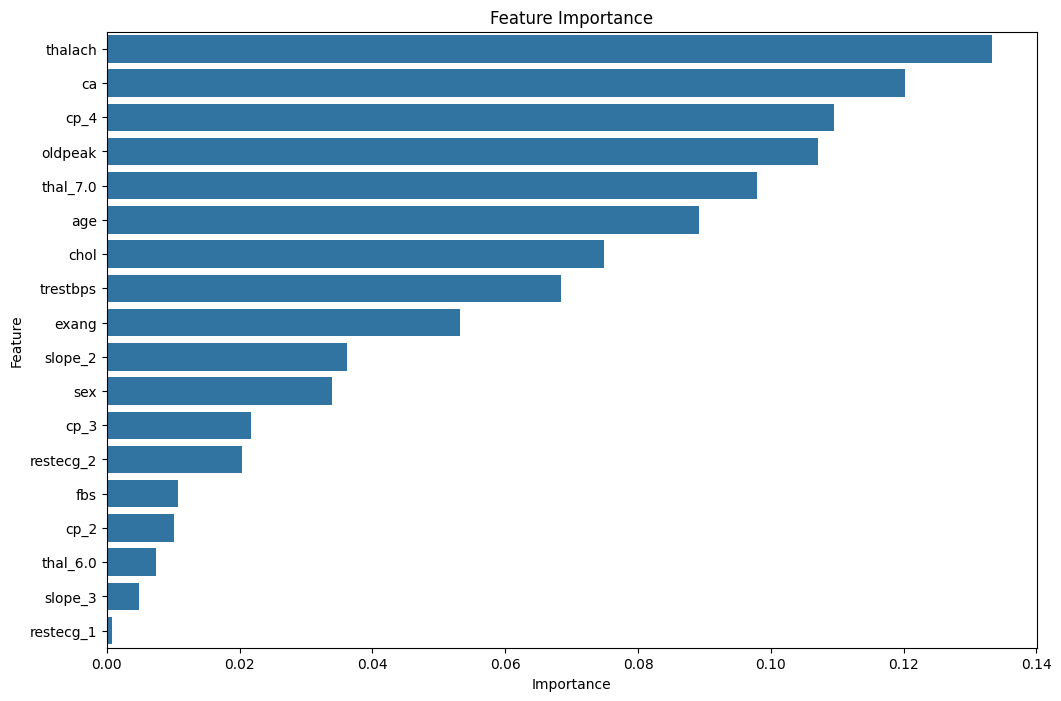

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance)
plt.title('Feature Importance')
plt.show()

In [ ]:
# Recursive Feature Elimination
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)
rfe.fit(X, y)
selected_features = X.columns[rfe.support_]
print("Selected features from RFE:", selected_features)

Selected features from RFE: Index(['age', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_4',
       'slope_2', 'thal_7.0'],
      dtype='object')


In [ ]:
# Chi-Square Test
# chi_selector = SelectKBest(chi2, k=10)
# chi_selector.fit(X, y)
# chi_support = chi_selector.get_support()
# chi_features = X.loc[:, chi_support].columns.tolist()
# print("Selected features from Chi-Square:", chi_features)

In [ ]:
# Final feature selection (Using RFE selected features)
final_features = selected_features
X_selected = X[final_features]

print("Final selected features:", final_features)

Final selected features: Index(['age', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_4',
       'slope_2', 'thal_7.0'],
      dtype='object')


#5. Supervised Learning Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score , confusion_matrix

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

In [ ]:
# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'report': classification_report(y_test, y_pred)
    }

    print(f"\n{name} Performance:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"ROC AUC: {results[name]['roc_auc']:.4f}")
    print(classification_report(y_test, y_pred))


Logistic Regression Performance:
Accuracy: 0.8525
ROC AUC: 0.9181
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61


Decision Tree Performance:
Accuracy: 0.7377
ROC AUC: 0.7338
              precision    recall  f1-score   support

           0       0.76      0.66      0.70        29
           1       0.72      0.81      0.76        32

    accuracy                           0.74        61
   macro avg       0.74      0.73      0.73        61
weighted avg       0.74      0.74      0.74        61


Random Forest Performance:
Accuracy: 0.8361
ROC AUC: 0.9364
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        29
           1       0.92      0.75      0.83     

#6. Unsupervised Learning (Clustering)

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
# K-Means Clustering
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_selected)
    wcss.append(kmeans.inertia_)

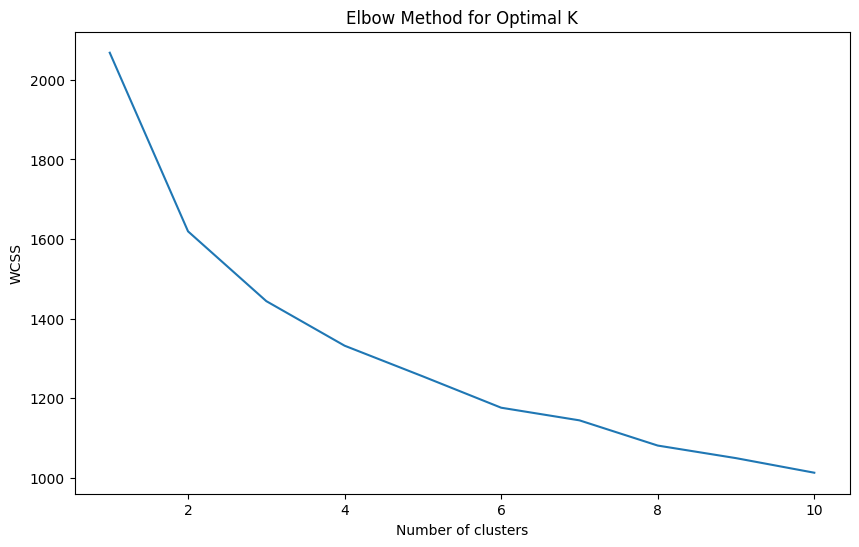

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# Optimal K=2 based on elbow method
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_selected)

In [ ]:
# Compare with actual labels
print("KMeans clustering vs actual labels:")
print(pd.crosstab(y, clusters))

KMeans clustering vs actual labels:
col_0     0    1
target          
0        36  128
1       101   38


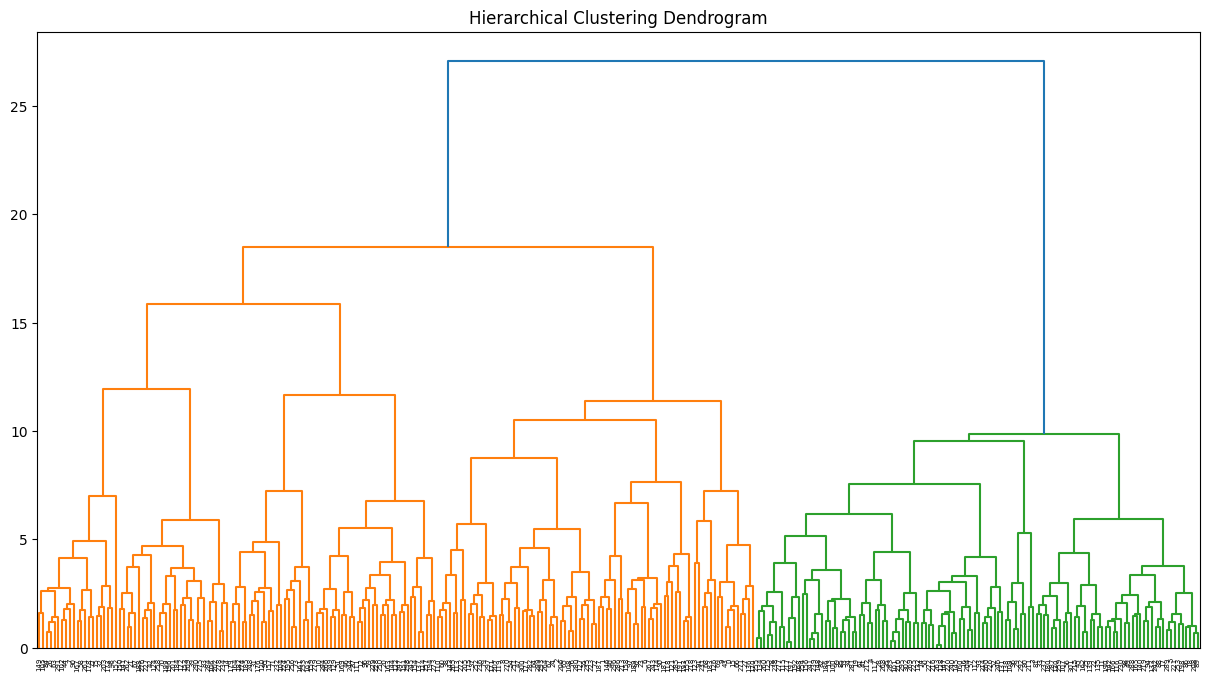

In [ ]:
# Hierarchical Clustering
linked = linkage(X_selected, 'ward')
plt.figure(figsize=(15, 8))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

#7. Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Tune Random Forest (best performing model)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                          cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [ ]:
# Evaluate best model
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("\nOptimized Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
print(classification_report(y_test, y_pred))


Optimized Random Forest Performance:
Accuracy: 0.8852
ROC AUC: 0.9504
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.88      0.89        32

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



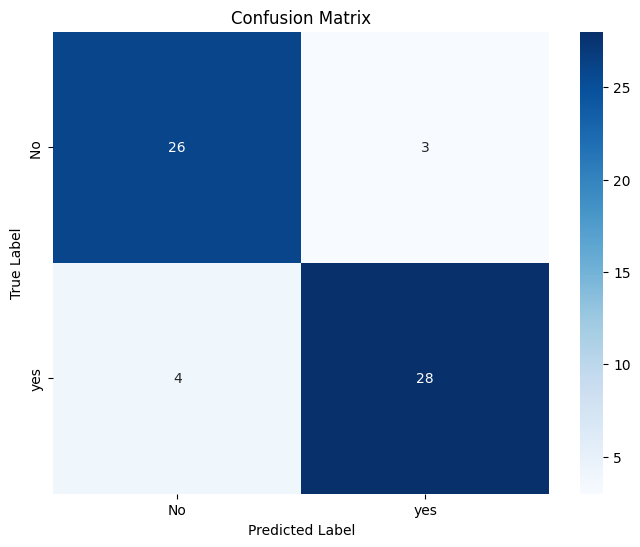

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'yes'], yticklabels=['No ', 'yes'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#8. Model Export & Deployment

In [ ]:
import os

# Create the 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

In [ ]:
import joblib

# Save the best model and pipeline
joblib.dump(best_rf, 'models/final_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(imputer, 'models/imputer.pkl')

# Save feature names
with open('models/selected_features.txt', 'w') as f:
    f.write('\n'.join(final_features))

#9. Streamlit UI Development (Bonus)

In [ ]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load model and assets
@st.cache_resource
def load_assets():
    model = joblib.load('models/final_model.pkl')
    scaler = joblib.load('models/scaler.pkl')
    with open('models/selected_features.txt', 'r') as f:
        features = [line.strip() for line in f]
    return model, scaler, features

model, scaler, selected_features = load_assets()

# Prediction logic
def predict_heart_disease(model, scaler, features, input_data):
    input_df = pd.DataFrame({feature: [0] for feature in features})

    for key in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak',
                'sex', 'fbs', 'exang', 'ca', 'restecg']:
        input_df[key] = input_data[key]

    # One-hot encodings
    cp_map = {0: 'cp_1', 1: 'cp_2', 2: 'cp_3', 3: 'cp_4'}
    slope_map = {0: 'slope_1', 1: 'slope_2', 2: 'slope_3'}
    thal_map = {0: 'thal_6.0', 1: 'thal_7.0', 2: 'thal_3'}

    if input_data['cp'] in cp_map:
        input_df[cp_map[input_data['cp']]] = 1
    if input_data['slope'] in slope_map:
        input_df[slope_map[input_data['slope']]] = 1
    if input_data['thal'] in thal_map:
        input_df[thal_map[input_data['thal']]] = 1

    # Scale numerical features
    num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    input_df[num_cols] = scaler.transform(input_df[num_cols])

    input_df = input_df[features]

    prediction = model.predict(input_df)[0]
    prediction_proba = model.predict_proba(input_df)[0]

    return prediction, prediction_proba

# Streamlit UI
st.set_page_config(page_title="Heart Health Assessment", layout="centered", page_icon="❤️")
st.title("❤️ Heart Health Assessment Tool")
st.markdown("""
This simple assessment estimates your heart disease risk based on key health indicators.
**Please note:** This is not a medical diagnosis. Always consult with your healthcare provider.
""")

# --- Form ---
with st.form("health_form"):
    st.header("Your Health Information")
    st.write("Please provide the following details to assess your heart health:")

    col1, col2 = st.columns(2)

    with col1:
        age = st.slider("Your age", 20, 100, 50,
                       help="Age is an important factor in heart health assessment")

        sex = st.radio("Gender", ["Male", "Female", "Prefer not to say"],
                      help="Biological sex can influence heart disease risk factors")

        trestbps = st.slider("Resting blood pressure (mm Hg)", 80, 200, 120,
                            help="Your blood pressure when at rest")

        chol = st.slider("Cholesterol level (mg/dL)", 100, 600, 200,
                         help="Total cholesterol level from your most recent blood test")

        thalach = st.slider("Highest heart rate achieved during exercise", 70, 210, 150,
                           help="If you don't know, estimate based on your exercise experience")

        oldpeak = st.slider("ST depression (if known)", 0.0, 6.0, 1.0, step=0.1,
                           help="From electrocardiogram (ECG) results, if available")

    with col2:
        fbs = st.radio("Fasting blood sugar > 120 mg/dl?", ["No", "Yes", "Not sure"],
                      help="From your most recent blood test")

        exang = st.radio("Do you experience chest pain during exercise?", ["No", "Yes", "Sometimes"],
                         help="Known as 'exercise-induced angina'")

        st.subheader("If you have ECG results:")
        restecg_options = {
            "Normal": 0,
            "ST-T wave abnormality": 1,
            "Possible left ventricular hypertrophy": 2
        }
        restecg = st.selectbox("Resting ECG results", list(restecg_options.keys()),
                               help="From your most recent electrocardiogram")

        cp_options = {
            "No chest pain": 0,
            "Typical angina (chest pain related to heart)": 1,
            "Atypical angina (other chest pain)": 2,
            "Non-anginal pain (not heart-related)": 3
        }
        cp = st.selectbox("Chest pain type (if any)", list(cp_options.keys()))

        slope_options = {
            "Upsloping": 0,
            "Flat": 1,
            "Downsloping": 2
        }
        slope = st.selectbox("ST segment slope (from ECG)", list(slope_options.keys()),
                            help="From electrocardiogram results")

        thal_options = {
            "Normal blood flow": 0,
            "Fixed defect (reduced blood flow)": 1,
            "Reversible defect (variable blood flow)": 2
        }
        thal = st.selectbox("Thalassemia (if known)", list(thal_options.keys()),
                          help="A blood disorder that can affect heart health")

        ca = st.slider("Number of major vessels seen on fluoroscopy", 0, 3, 0,
                      help="From coronary angiography if performed (0 = none)")

    submitted = st.form_submit_button("Assess My Heart Health")

# --- Prediction ---
if submitted:
    # Convert inputs to model format
    input_data = {
        "age": age,
        "sex": 1 if sex == "Male" else 0,
        "trestbps": trestbps,
        "chol": chol,
        "thalach": thalach,
        "oldpeak": oldpeak,
        "fbs": 1 if fbs == "Yes" else 0,
        "exang": 1 if exang == "Yes" else (0.5 if exang == "Sometimes" else 0),
        "restecg": restecg_options[restecg],
        "cp": cp_options[cp],
        "slope": slope_options[slope],
        "thal": thal_options[thal],
        "ca": ca
    }

    with st.spinner("Analyzing your health information..."):
        try:
            pred, proba = predict_heart_disease(model, scaler, selected_features, input_data)
        except:
            st.error("We encountered an issue processing your information. Please try again or consult your doctor.")
            st.stop()

    # --- Display Results ---
    st.header("Your Heart Health Assessment")
    st.markdown("---")

    # Main result card
    with st.container():
        if pred == 1:
            st.error("""
            ## 🔍 Potential Heart Health Concern Detected
            Based on the information provided, this assessment suggests you may be at risk for heart disease.
            """)
        else:
            st.success("""
            ## 🌟 No Significant Heart Health Concerns Detected
            Based on the information provided, this assessment doesn't indicate significant heart disease risk.
            """)

        st.info("""
        **Remember:** This is not a medical diagnosis. It's an automated assessment based on the information you provided.
        Always consult with your healthcare provider about your heart health.
        """)

    # Risk visualization
    st.subheader("Risk Assessment Breakdown")

    col1, col2 = st.columns(2)

    with col1:
        st.metric(label="Healthy Heart Likelihood", value=f"{proba[0]*100:.1f}%")
        st.progress(proba[0])

    with col2:
        st.metric(label="Potential Heart Disease Risk", value=f"{proba[1]*100:.1f}%")
        st.progress(proba[1])

    # Personalized guidance
    st.subheader("Recommended Next Steps")

    if pred == 1:
        if proba[1] > 0.9:
            st.error("""
            **🛑 High Risk Indicated**
            Please schedule an appointment with your doctor or cardiologist as soon as possible
            to discuss these results and your heart health.
            """)
        elif proba[1] > 0.7:
            st.warning("""
            **⚠️ Moderate to High Risk Indicated**
            We recommend consulting with your healthcare provider about these results
            and considering a heart health check-up.
            """)
        else:
            st.info("""
            **🔍 Slight Risk Indicated**
            While not immediately concerning, it may be worth discussing these results
            at your next regular check-up.
            """)
    else:
        if proba[0] > 0.9:
            st.success("""
            **🌟 Excellent Heart Health Indicators**
            Your results suggest good heart health. Keep up any healthy habits you have!
            """)
        else:
            st.info("""
            **👍 Generally Positive Results**
            Your results don't indicate significant concerns, but regular check-ups
            are always a good idea for maintaining heart health.
            """)

    # Health tips
    st.subheader("Heart Health Tips for Everyone")

    tips = """
    - 🏃‍♂️ Get regular physical activity (150 minutes moderate exercise per week)
    - 🥗 Eat a heart-healthy diet (plenty of vegetables, whole grains, lean proteins)
    - 🚭 Avoid tobacco products
    - 🍷 Limit alcohol consumption
    - 😴 Get 7-9 hours of quality sleep each night
    - 🧘‍♀️ Manage stress through relaxation techniques
    - 🩺 Schedule regular check-ups with your doctor
    """
    st.markdown(tips)

    # Data summary (simplified)
    expander = st.expander("Review the information you provided")
    with expander:
        st.json({
            "Demographics": {
                "Age": age,
                "Gender": sex
            },
            "Vital Signs": {
                "Blood Pressure": f"{trestbps} mm Hg",
                "Cholesterol": f"{chol} mg/dL",
                "Max Heart Rate": thalach
            },
            "Symptoms": {
                "Chest Pain": cp,
                "Exercise Pain": exang
            },
            "Test Results": {
                "ECG Findings": restecg,
                "ST Depression": oldpeak,
                "Fluoroscopy Vessels": ca
            }
        })

# Footer
st.markdown("---")
st.markdown("""
**Disclaimer:** This tool is for informational purposes only and is not a substitute for professional medical advice,
diagnosis, or treatment. Always seek the advice of your physician or other qualified health provider with any
questions you may have regarding a medical condition.
""")

Writing app.py


#10. Deployment using Ngrok [Bonus]


In [ ]:
pip install pyngrok

In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token("your authtoken") # Replace with your actual authtoken

In [ ]:
!ngrok authtoken your authtoken

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
#!streamlit run app.py

In [ ]:
!streamlit run app.py &>/dev/null&

In [ ]:
#Replace your existing ngrok connection with:
public_url = ngrok.connect(addr='8501', proto='http')  # Explicit protocol
print("Your app is live at:", public_url)

Your app is live at: NgrokTunnel: "https://65fb6afd17c2.ngrok-free.app" -> "http://localhost:8501"
